# Health data sharing is caring

### Import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.io import imread_collection
from matplotlib import gridspec
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
import glob
import imageio
from sklearn.cluster import KMeans

### Example

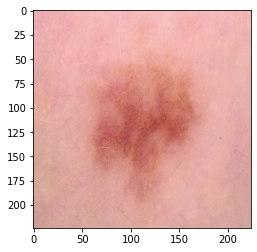

In [2]:
img=mpimg.imread('benign/23.jpg')
imgplot = plt.imshow(img)

### Size of image

In [3]:
np.shape(img)

(224, 224, 3)

### Example of skin patch

In [4]:
rgb = 3

w_h = 10 #n of pixels vertically for skin patch
w_v = 10 #n of pixels horizontally for skin patch

pxl_h = 10 #row pixel number
pxl_v = 214 #column pixel number

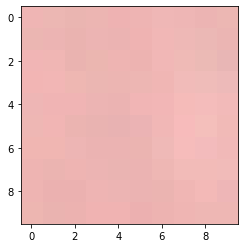

In [5]:
plt.imshow(img[pxl_h:pxl_h+w_h, pxl_v:pxl_v+w_v,:])
plt.show()

## Load data

In [6]:
clr = [] #skin color

benign = []

patch_matrix = []

for image_path in glob.glob('benign/*.jpg'):
    patch = imageio.imread(image_path)[pxl_h:pxl_h+w_h, pxl_v:pxl_v+w_v,:]
    patch_matrix.append(patch)
    patch_reshape = np.reshape(patch, (10*10*3)).tolist()
    benign.append(patch_reshape)
    
    clr.append(np.reshape(patch, (10*10, 3)).mean(axis=0))

### How many images?

In [7]:
tot_fig = len(benign)

In [8]:
tot_fig

660

### Sort them for plotting, according to darkness (scale)

In [9]:
img_patch = np.zeros((tot_fig, w_h, w_h, rgb))

scale = np.zeros((tot_fig))
#red = np.zeros((tot_fig))

for i in range(0, tot_fig):
    scale[i] = patch_matrix[i].mean()
    #red[i] = img_patch[i,:,:,0].mean()
    
idx = np.argsort(scale)[::-1]
#idx = np.argsort(red)[::-1]

### Plot skin patches

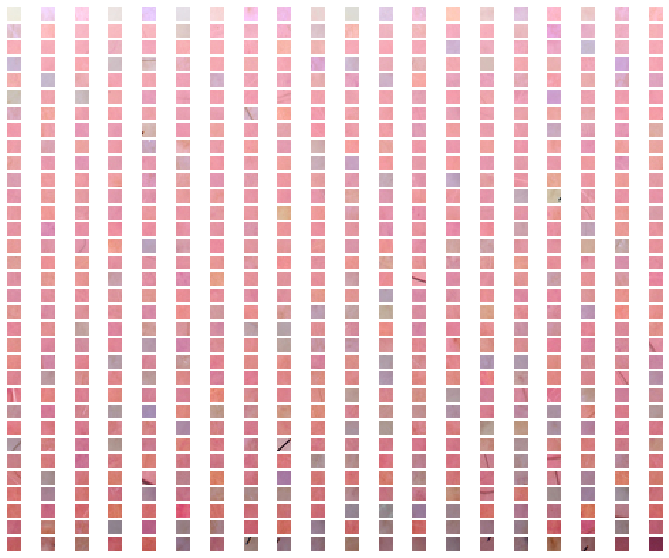

In [10]:
plt.figure(figsize=(12,10))

for j, ID in enumerate(idx):
    ax = plt.subplot(33, 20, j+1)
    #ax = plt.subplot(5, 2, j+1)
    ax.imshow(patch_matrix[ID])
    ax.axis('off')
    
#plt.subplots_adjust(wspace=0, hspace=0)    
plt.show()

### Import all data

In [11]:
clr = [] #skin color

benign = []

for image_path in glob.glob('benign/*.jpg'):
    patch = imageio.imread(image_path)[pxl_h:pxl_h+w_h, pxl_v:pxl_v+w_v,:]
    patch_reshape = np.reshape(patch, (w_h*w_v*rgb)).tolist()
    benign.append(patch_reshape)
    
    clr.append(np.reshape(patch, (w_h*w_v, rgb)).mean(axis=0))

for b in benign: #No disease
    b.append(0)
    
benign2 = []
    
for image_path in glob.glob('benign2/*.jpg'):
    patch = imageio.imread(image_path)[pxl_h:pxl_h+w_h, pxl_v:pxl_v+w_v,:]
    patch_reshape = np.reshape(patch, (w_h*w_v*rgb)).tolist()
    benign2.append(patch_reshape)
    
    clr.append(np.reshape(patch, (w_h*w_v, rgb)).mean(axis=0))

for b in benign2: #No disease
    b.append(0)
    
malignant = []
    
for image_path in glob.glob('malignant/*.jpg'):
    patch = imageio.imread(image_path)[pxl_h:pxl_h+w_h, pxl_v:pxl_v+w_v,:]
    patch_reshape = np.reshape(patch, (w_h*w_v*rgb)).tolist()
    malignant.append(patch_reshape)
    
    clr.append(np.reshape(patch, (w_h*w_v, rgb)).mean(axis=0))
    
for m in malignant: #Disease
    m.append(1)

In [12]:
data = benign + benign2 + malignant

In [13]:
for i, d in enumerate(data): #skin darkness
    d.append(clr[i].mean())

In [14]:
df = pd.DataFrame(data)
df.rename({300: 'Disease', 301: 'Skin'}, axis=1, inplace=True)

In [15]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,Disease,Skin
0,219,160,164,217,161,164,217,160,166,220,...,160,173,211,156,162,212,157,162,0,172.876667
1,217,129,143,209,127,141,214,127,143,214,...,124,139,206,124,138,209,122,139,0,157.366667
2,203,131,143,199,126,137,203,130,141,198,...,122,134,201,131,142,205,142,153,0,154.396667
3,150,100,103,150,100,109,149,99,108,148,...,102,114,154,104,116,155,105,116,0,114.253333
4,241,174,192,239,172,190,233,169,185,239,...,169,185,234,172,187,235,172,189,0,198.830000


In [16]:
features = [i for i in df.columns[0:-2]]

In [17]:
x = df.loc[:, features].values # Separating out the features

pca = PCA(n_components=2)
PC = pca.fit_transform(x)
df['PC1'] = pd.Series(PC[:,0])
df['PC2'] = pd.Series(PC[:,1])

## Plot variability of skin colour and malignant mole (circle=healthy, star=disease)

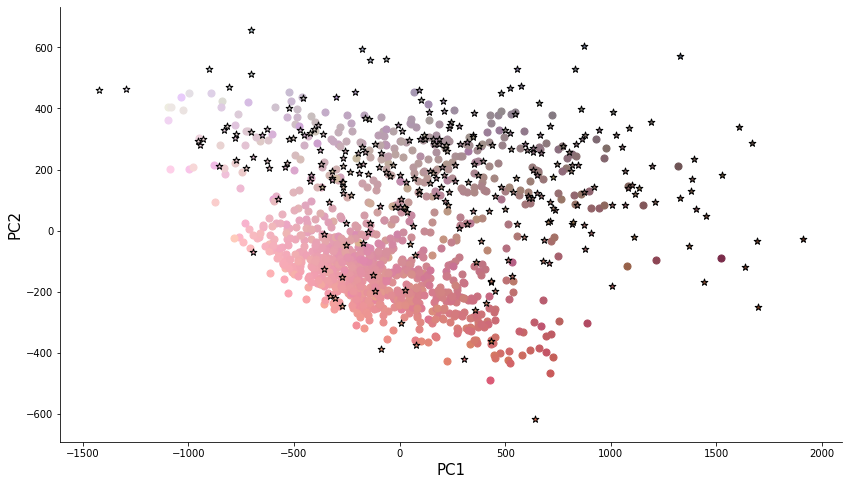

In [18]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)

for i in df.index:
    cl = [i/255 for i in clr[i]]
    cl = np.reshape(cl, (1,3))
    
    if df.loc[i, 'Disease'] == 0:
        ax.scatter(df.loc[i, 'PC1'], df.loc[i, 'PC2'], c = cl, s = 50, marker='o')
        
    elif df.loc[i, 'Disease'] == 1:
        ax.scatter(df.loc[i, 'PC1'], df.loc[i, 'PC2'], c = cl, s = 0, marker='*', edgecolor='k')
        
for i in df.index:
    cl = [i/255 for i in clr[i]]
    cl = np.reshape(cl, (1,3))
    
    if df.loc[i, 'Disease'] == 0:
        ax.scatter(df.loc[i, 'PC1'], df.loc[i, 'PC2'], c = cl, s = 0, marker='o')
        
    elif df.loc[i, 'Disease'] == 1:
        ax.scatter(df.loc[i, 'PC1'], df.loc[i, 'PC2'], c = cl, s = 50, marker='*', edgecolor='k')
    

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

### Capture main skin color - unsupervised learning

In [19]:
Z = np.zeros((len(data), 2))
Z[:,0] = df['PC1'].values
Z[:,1] = df['PC2'].values

In [20]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(Z) #clustering

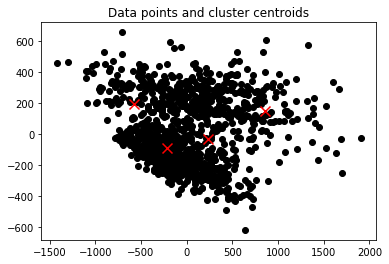

In [21]:
# Plotting the cluster centers and the data points on a 2D plane
plt.scatter(Z[:, 0], Z[:, -1], color='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.title('Data points and cluster centroids')
plt.show()

In [22]:
kmeans.cluster_centers_

array([[ 853.94631182,  146.5050202 ],
       [-214.65996312,  -90.11019126],
       [ 231.39102374,  -34.1977265 ],
       [-580.48889191,  192.7260742 ]])

In [23]:
centre = kmeans.cluster_centers_[1]

In [24]:
dist = np.sqrt ( (centre[0]- Z[:,0])**2 + (centre[1]- Z[:,1])**2 )

In [25]:
df['dist'] = pd.Series(dist)

### Classification - supervised learning

In [26]:
clf = MLPClassifier(alpha=1, max_iter=1000)

X = x
y = df['Disease']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=42)

clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print (clf)
print (score)
print ()

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
0.8065395095367848



### Take average accuracy

In [27]:
score_def = []

kf = KFold(n_splits=5, random_state=None, shuffle=True)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    score_def.append(clf.score(X_test, y_test))

### Sort by skin colour (distance from main skin colour)

In [28]:
#df = df.sort_values(by=['Skin'])
df = df.sort_values(by=['dist'])

In [29]:
#perc = [0.05, 0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#perc = np.arange(0.05, 1, 0.05)

perc = np.arange(0.1, 1, 0.05) #percentage of dataset for training

X = df.iloc[:, features]
y = df['Disease']

kfold = range(0,20)
score = np.zeros((len(perc), len(kfold)))

for p_idx, p in enumerate(perc):
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=1-p, shuffle=False)
    
    for k in kfold:
        clf.fit(X_train, y_train)
        score[p_idx, k] = clf.score(X_test, y_test)

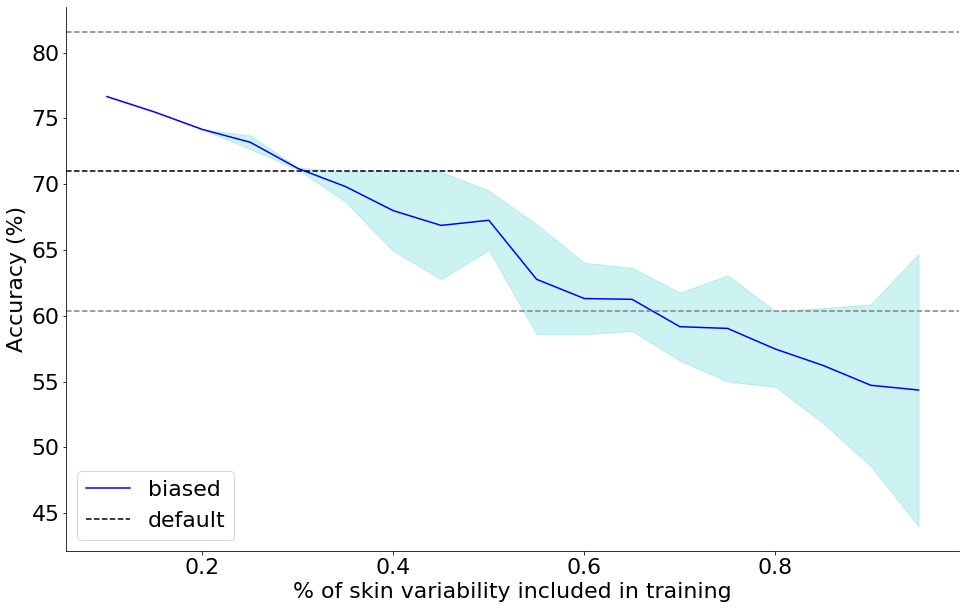

In [32]:
Y = score.mean(axis=1)*100
error = score.std(axis=1)*100
score_d = np.array(score_def)

plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1,1,1)
plt.plot(perc, Y, color='b', label='biased')
plt.fill_between(perc, Y-error, Y+error, alpha=0.2, edgecolor='c', facecolor='c')
plt.axhline(y=score_d.mean()*100, color='k', linestyle='--', label='default')
plt.axhline(y=score_d.mean()*100+score_d.std()*100, color=[.5, .5, .5], linestyle='--')
plt.axhline(y=score_d.mean()*100-score_d.std()*100, color=[.5, .5, .5], linestyle='--')
plt.xlabel('% of skin variability included in training')
plt.ylabel('Accuracy (%)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.show()

# VARIABILITY MATTERS!